In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline



In [2]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
import os

In [3]:
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

In [4]:
RANDOM_SEED = 123
BATCH_SIZE = 64
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LR = 0.1
NUM_ATTRIBUTE = 12
NUM_HIDDEN_1 = 1024
NUM_HIDDEN_2 = 1024
NUM_CLASS = 6
OUTCOME = 'genre'

In [5]:
set_all_seeds(RANDOM_SEED)
set_deterministic()

# Load Data

In [6]:
class MyDataset(Dataset):

    def __init__(self, csv_path):
    
        df = pd.read_csv(csv_path)
        
        self.x = torch.tensor(df.iloc[:, :NUM_ATTRIBUTE].values).float()
        self.y = torch.tensor(df[OUTCOME].values).long()
        
        mean = torch.mean(self.x, dim=0)
        std = torch.std(self.x, dim=0)
        self.x = (self.x - mean)/std
        #print(len(self.x))
        #print(len(self.y))

    def __getitem__(self, index):
        attributes = self.x[index]
        label = self.y[index]
        return attributes, label

    def __len__(self):
        return self.y.shape[0]

In [15]:

train_dataset = MyDataset(csv_path='class_data/spotify_train.csv')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0) # number processes/CPUs to use

valid_dataset = MyDataset(csv_path='class_data/spotify_valid.csv')

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0)



test_dataset = MyDataset(csv_path='class_data/spotify_test.csv')

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0)

In [16]:
for attributes, labels in train_loader:  
    print('Image batch dimensions:', attributes.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 12])
Image label dimensions: torch.Size([64])


# ONE-HOT CODE

In [17]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    tmp = y.view(-1, 1).long().to(torch.device('cpu'))
    y_onehot.scatter_(1, tmp, 1).float()
    return y_onehot

# Model

In [18]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, drop_proba, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        self.my_network = torch.nn.Sequential(
            ### 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.Dropout(drop_proba),
            ### 2nd hidden layer
            torch.nn.Linear(num_hidden_1, num_hidden_2, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_2),
            torch.nn.Dropout(drop_proba),
            ### Output layer
            torch.nn.Linear(num_hidden_2, num_classes)
        )
        
        '''
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### 1st hidden layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()

        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        '''
        
    def forward(self, x):
        logits = self.my_network(x)
        return logits
        '''
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        logits = self.linear_out(out)
        #probas = F.log_softmax(logits, dim=1)
        return logits#, probas
        '''

## Model Initialization with BatchNorm

Epoch: 001/100 | Batch 0000/0410 | Loss: 2.0722
Epoch: 001/100 | Batch 0050/0410 | Loss: 2.3266
Epoch: 001/100 | Batch 0100/0410 | Loss: 2.1411
Epoch: 001/100 | Batch 0150/0410 | Loss: 1.5489
Epoch: 001/100 | Batch 0200/0410 | Loss: 1.9957
Epoch: 001/100 | Batch 0250/0410 | Loss: 2.5302
Epoch: 001/100 | Batch 0300/0410 | Loss: 1.8904
Epoch: 001/100 | Batch 0350/0410 | Loss: 2.6199
Epoch: 001/100 | Batch 0400/0410 | Loss: 2.3690
Epoch: 001/100 | Train: 40.35% | Validation: 39.89%
Time elapsed: 0.06 min
Epoch: 002/100 | Batch 0000/0410 | Loss: 2.1430
Epoch: 002/100 | Batch 0050/0410 | Loss: 2.8161
Epoch: 002/100 | Batch 0100/0410 | Loss: 2.1963
Epoch: 002/100 | Batch 0150/0410 | Loss: 1.7331
Epoch: 002/100 | Batch 0200/0410 | Loss: 1.9531
Epoch: 002/100 | Batch 0250/0410 | Loss: 2.2422
Epoch: 002/100 | Batch 0300/0410 | Loss: 1.7497
Epoch: 002/100 | Batch 0350/0410 | Loss: 2.2668
Epoch: 002/100 | Batch 0400/0410 | Loss: 1.9147
Epoch: 002/100 | Train: 45.15% | Validation: 45.62%
Time elap

Epoch: 017/100 | Batch 0100/0410 | Loss: 1.2821
Epoch: 017/100 | Batch 0150/0410 | Loss: 1.4557
Epoch: 017/100 | Batch 0200/0410 | Loss: 1.3356
Epoch: 017/100 | Batch 0250/0410 | Loss: 1.5936
Epoch: 017/100 | Batch 0300/0410 | Loss: 1.2615
Epoch: 017/100 | Batch 0350/0410 | Loss: 1.2868
Epoch: 017/100 | Batch 0400/0410 | Loss: 1.5530
Epoch: 017/100 | Train: 52.42% | Validation: 51.34%
Time elapsed: 0.93 min
Epoch: 018/100 | Batch 0000/0410 | Loss: 1.2696
Epoch: 018/100 | Batch 0050/0410 | Loss: 1.4193
Epoch: 018/100 | Batch 0100/0410 | Loss: 1.5708
Epoch: 018/100 | Batch 0150/0410 | Loss: 1.4989
Epoch: 018/100 | Batch 0200/0410 | Loss: 1.3091
Epoch: 018/100 | Batch 0250/0410 | Loss: 1.0864
Epoch: 018/100 | Batch 0300/0410 | Loss: 1.0912
Epoch: 018/100 | Batch 0350/0410 | Loss: 1.3960
Epoch: 018/100 | Batch 0400/0410 | Loss: 1.1467
Epoch: 018/100 | Train: 53.61% | Validation: 51.71%
Time elapsed: 0.99 min
Epoch: 019/100 | Batch 0000/0410 | Loss: 1.3105
Epoch: 019/100 | Batch 0050/0410 |

Epoch: 033/100 | Batch 0200/0410 | Loss: 1.2311
Epoch: 033/100 | Batch 0250/0410 | Loss: 1.3163
Epoch: 033/100 | Batch 0300/0410 | Loss: 1.2115
Epoch: 033/100 | Batch 0350/0410 | Loss: 1.0853
Epoch: 033/100 | Batch 0400/0410 | Loss: 1.2137
Epoch: 033/100 | Train: 55.47% | Validation: 52.62%
Time elapsed: 1.82 min
Epoch: 034/100 | Batch 0000/0410 | Loss: 1.4174
Epoch: 034/100 | Batch 0050/0410 | Loss: 1.2609
Epoch: 034/100 | Batch 0100/0410 | Loss: 1.4137
Epoch: 034/100 | Batch 0150/0410 | Loss: 1.2255
Epoch: 034/100 | Batch 0200/0410 | Loss: 1.3763
Epoch: 034/100 | Batch 0250/0410 | Loss: 1.4060
Epoch: 034/100 | Batch 0300/0410 | Loss: 1.3917
Epoch: 034/100 | Batch 0350/0410 | Loss: 1.1850
Epoch: 034/100 | Batch 0400/0410 | Loss: 1.3587
Epoch: 034/100 | Train: 55.64% | Validation: 52.98%
Time elapsed: 1.87 min
Epoch: 035/100 | Batch 0000/0410 | Loss: 1.2827
Epoch: 035/100 | Batch 0050/0410 | Loss: 1.3457
Epoch: 035/100 | Batch 0100/0410 | Loss: 1.1056
Epoch: 035/100 | Batch 0150/0410 |

Epoch: 049/100 | Batch 0300/0410 | Loss: 1.2350
Epoch: 049/100 | Batch 0350/0410 | Loss: 1.4536
Epoch: 049/100 | Batch 0400/0410 | Loss: 1.2534
Epoch: 049/100 | Train: 56.33% | Validation: 53.17%
Time elapsed: 2.78 min
Epoch: 050/100 | Batch 0000/0410 | Loss: 1.1268
Epoch: 050/100 | Batch 0050/0410 | Loss: 1.1388
Epoch: 050/100 | Batch 0100/0410 | Loss: 1.2314
Epoch: 050/100 | Batch 0150/0410 | Loss: 1.1830
Epoch: 050/100 | Batch 0200/0410 | Loss: 1.1920
Epoch: 050/100 | Batch 0250/0410 | Loss: 1.2463
Epoch: 050/100 | Batch 0300/0410 | Loss: 1.4341
Epoch: 050/100 | Batch 0350/0410 | Loss: 1.0379
Epoch: 050/100 | Batch 0400/0410 | Loss: 1.4167
Epoch: 050/100 | Train: 56.39% | Validation: 53.17%
Time elapsed: 2.87 min
Epoch: 051/100 | Batch 0000/0410 | Loss: 1.2341
Epoch: 051/100 | Batch 0050/0410 | Loss: 1.1244
Epoch: 051/100 | Batch 0100/0410 | Loss: 1.2229
Epoch: 051/100 | Batch 0150/0410 | Loss: 1.3279
Epoch: 051/100 | Batch 0200/0410 | Loss: 1.2354
Epoch: 051/100 | Batch 0250/0410 |

Epoch: 065/100 | Batch 0400/0410 | Loss: 1.1382
Epoch: 065/100 | Train: 56.85% | Validation: 53.59%
Time elapsed: 4.56 min
Epoch: 066/100 | Batch 0000/0410 | Loss: 1.0836
Epoch: 066/100 | Batch 0050/0410 | Loss: 1.1850
Epoch: 066/100 | Batch 0100/0410 | Loss: 1.2732
Epoch: 066/100 | Batch 0150/0410 | Loss: 1.1029
Epoch: 066/100 | Batch 0200/0410 | Loss: 1.1168
Epoch: 066/100 | Batch 0250/0410 | Loss: 1.1427
Epoch: 066/100 | Batch 0300/0410 | Loss: 1.0159
Epoch: 066/100 | Batch 0350/0410 | Loss: 1.1624
Epoch: 066/100 | Batch 0400/0410 | Loss: 1.3386
Epoch: 066/100 | Train: 57.05% | Validation: 53.78%
Time elapsed: 4.69 min
Epoch: 067/100 | Batch 0000/0410 | Loss: 1.1377
Epoch: 067/100 | Batch 0050/0410 | Loss: 1.0654
Epoch: 067/100 | Batch 0100/0410 | Loss: 1.2314
Epoch: 067/100 | Batch 0150/0410 | Loss: 1.4072
Epoch: 067/100 | Batch 0200/0410 | Loss: 1.3445
Epoch: 067/100 | Batch 0250/0410 | Loss: 1.2424
Epoch: 067/100 | Batch 0300/0410 | Loss: 1.3610
Epoch: 067/100 | Batch 0350/0410 |

Epoch: 082/100 | Batch 0050/0410 | Loss: 1.2685
Epoch: 082/100 | Batch 0100/0410 | Loss: 1.1232
Epoch: 082/100 | Batch 0150/0410 | Loss: 1.1828
Epoch: 082/100 | Batch 0200/0410 | Loss: 1.3818
Epoch: 082/100 | Batch 0250/0410 | Loss: 1.0879
Epoch: 082/100 | Batch 0300/0410 | Loss: 1.0739
Epoch: 082/100 | Batch 0350/0410 | Loss: 1.1367
Epoch: 082/100 | Batch 0400/0410 | Loss: 1.1992
Epoch: 082/100 | Train: 57.52% | Validation: 53.65%
Time elapsed: 6.56 min
Epoch: 083/100 | Batch 0000/0410 | Loss: 1.2725
Epoch: 083/100 | Batch 0050/0410 | Loss: 1.1424
Epoch: 083/100 | Batch 0100/0410 | Loss: 1.2566
Epoch: 083/100 | Batch 0150/0410 | Loss: 1.1249
Epoch: 083/100 | Batch 0200/0410 | Loss: 1.2757
Epoch: 083/100 | Batch 0250/0410 | Loss: 1.2937
Epoch: 083/100 | Batch 0300/0410 | Loss: 1.3090
Epoch: 083/100 | Batch 0350/0410 | Loss: 1.3440
Epoch: 083/100 | Batch 0400/0410 | Loss: 1.1958
Epoch: 083/100 | Train: 57.52% | Validation: 53.53%
Time elapsed: 6.67 min
Epoch: 084/100 | Batch 0000/0410 |

Epoch: 098/100 | Batch 0150/0410 | Loss: 1.3532
Epoch: 098/100 | Batch 0200/0410 | Loss: 1.2347
Epoch: 098/100 | Batch 0250/0410 | Loss: 1.0441
Epoch: 098/100 | Batch 0300/0410 | Loss: 1.2541
Epoch: 098/100 | Batch 0350/0410 | Loss: 1.1623
Epoch: 098/100 | Batch 0400/0410 | Loss: 1.1322
Epoch: 098/100 | Train: 58.08% | Validation: 54.08%
Time elapsed: 8.47 min
Epoch: 099/100 | Batch 0000/0410 | Loss: 1.1486
Epoch: 099/100 | Batch 0050/0410 | Loss: 1.2673
Epoch: 099/100 | Batch 0100/0410 | Loss: 1.0435
Epoch: 099/100 | Batch 0150/0410 | Loss: 1.2381
Epoch: 099/100 | Batch 0200/0410 | Loss: 1.0263
Epoch: 099/100 | Batch 0250/0410 | Loss: 1.2489
Epoch: 099/100 | Batch 0300/0410 | Loss: 1.2549
Epoch: 099/100 | Batch 0350/0410 | Loss: 1.1735
Epoch: 099/100 | Batch 0400/0410 | Loss: 0.9826
Epoch: 099/100 | Train: 57.92% | Validation: 53.65%
Time elapsed: 8.60 min
Epoch: 100/100 | Batch 0000/0410 | Loss: 0.9144
Epoch: 100/100 | Batch 0050/0410 | Loss: 1.2730
Epoch: 100/100 | Batch 0100/0410 |

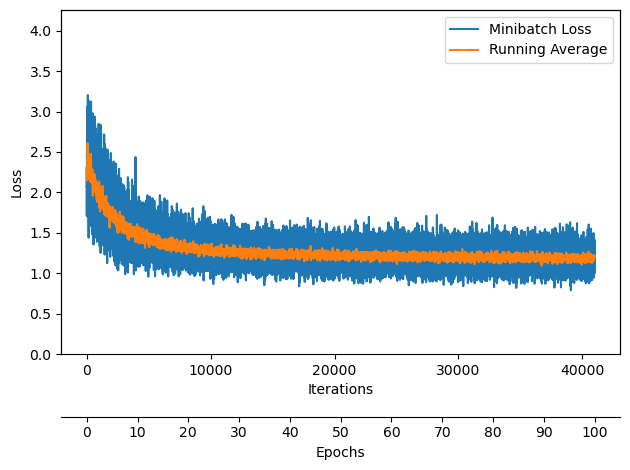

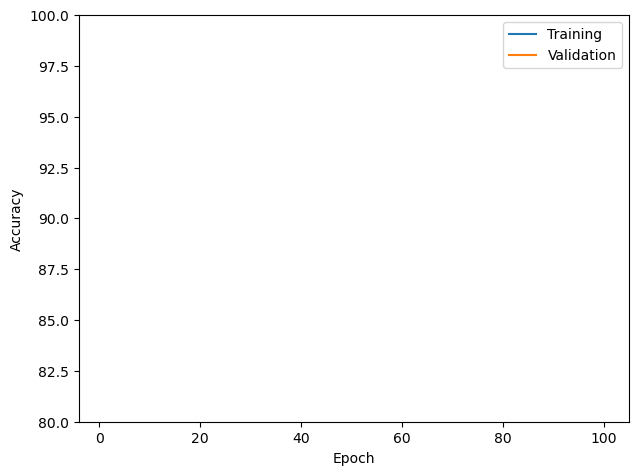

In [19]:
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=NUM_ATTRIBUTE,
                             num_hidden_1=NUM_HIDDEN_1,
                             num_hidden_2=NUM_HIDDEN_2,
                             drop_proba=0.5,
                             num_classes=NUM_CLASS)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

In [20]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, NUM_ATTRIBUTE).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 58.02
Test Accuracy: 54.70


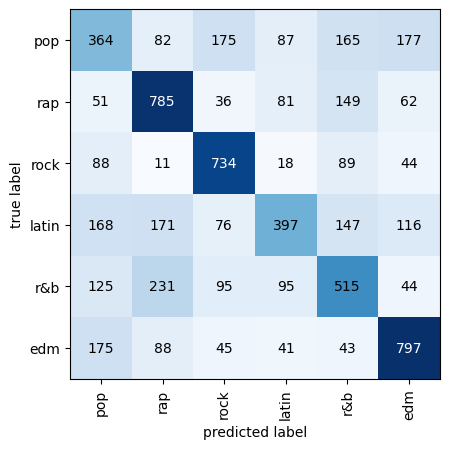

In [21]:
class_dict = {0: 'pop',
              1: 'rap',
              2: 'rock',
              3: 'latin',
              4: 'r&b',
              5: 'edm'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()